In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
msts = pd.read_pickle('data/min_spanning_trees.pkl')

In [6]:
# Import synapse and cell data
cells = pd.read_csv('data/cells_no_repeats.csv', index_col=0)
synapses_df = pd.read_csv('data/synapses_w_ids.csv', index_col=0)
synapses_df.set_index('synapse_id', inplace=True)
display(synapses_df.head())

,pre_pt_root_id,post_pt_root_id,size,cell_type_pre,cb_x_pre,cb_y_pre,cb_z_pre,cell_type_post,cb_x_post,cb_y_post,cb_z_post,cb_x_diff,cb_y_diff,cb_z_diff,ctr_pt_x,ctr_pt_y,ctr_pt_z
synapse_id,,,,,,,,,,,,,,,,,
0,864691135564683351,864691136811959667,960,23P,557.248,570.560,732.52,23P,791.744,483.968,780.44,-234.496,86.592,-47.92,637.608,371.352,720.20
1,864691135614119115,864691135508912649,7576,23P,774.720,504.960,895.68,23P,807.936,459.584,870.28,-33.216,45.376,25.40,805.376,488.376,863.60
3,864691135113147801,864691136022555784,684,23P,883.072,451.456,817.84,23P,851.520,483.840,759.96,31.552,-32.384,57.88,858.328,516.648,775.88
4,864691135194393642,864691135341362885,23172,23P,781.248,449.984,696.88,23P,798.720,465.152,758.56,-17.472,-15.168,-61.68,789.400,478.040,691.00
5,864691136272938174,864691135683554546,3660,23P,762.368,473.792,773.68,23P,820.352,446.784,719.08,-57.984,27.008,54.60,756.624,440.928,710.60


In [14]:
synapses = synapses_df[['ctr_pt_x', 'ctr_pt_y', 'ctr_pt_z', 'post_pt_root_id']]
display(synapses.head())

,ctr_pt_x,ctr_pt_y,ctr_pt_z,post_pt_root_id
synapse_id,,,,
0,637.608,371.352,720.20,864691136811959667
1,805.376,488.376,863.60,864691135508912649
3,858.328,516.648,775.88,864691136022555784
4,789.400,478.040,691.00,864691135341362885
5,756.624,440.928,710.60,864691135683554546


In [15]:
def traverse_branch(G, start_node, root_node):
    path = [root_node, start_node]
    node = start_node
    safeguard = root_node

    while G.degree(node) == 2:
        neighbors = np.array(list(G.neighbors(node)))
        next_node = neighbors[neighbors != path[-2]][0]

        safeguard = node
        node = next_node
        path.append(node)
    
    return path[1:], node, safeguard

# Given a graph and a root node, return a list of lists of nodes, where each list is a sequence of nodes such that each node is connected to the next node in the list and the last node in the list has degree > 2
def get_paths(G, root, entrance_node=None):
    paths = []
    
    root_neighbors = np.array(list(G.neighbors(root)))
    new_branches = root_neighbors[~np.isin(root_neighbors, entrance_node)]

    for node in new_branches:
        path, end_node, visited_node = traverse_branch(G, node, root)
        paths.append(path)

        if G.degree(end_node) > 2:
            paths.extend(get_paths(G, end_node, visited_node))
    
    return paths

def get_color_map(paths, root):
    colors = ['#ff0000', '#00ff00', '#0000ff', '#ffff00', '#00ffff', '#ff00ff', '#ff8000', '#8000ff', '#00ff80', '#ff0080']
    color_map = {node: colors[i % len(colors)] for i, path in enumerate(paths) for node in path}
    color_map[root] = '#a0a0a0'
    return color_map

In [24]:
# Plot the synapes of the minimum spanning tree in 3D and connect them with lines according to the minimum spanning tree
def plot_mst_3d(G, synapses, root=-1, paths=None):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    if paths is None:
        paths = get_paths(G, root)
    
    color_map = get_color_map(paths, root)

    for node, row in synapses.iterrows():
        ax.scatter(row['ctr_pt_x'], row['ctr_pt_y'],row['ctr_pt_z'], c=color_map[node], s=10)
    
    # Connect the synapses with lines according to the edges of the minimum spanning tree
    soma_pos = G.graph['soma_pos']
    for edge in G.edges():
        node1, node2 = edge
        if node1 == root:
            ax.plot([soma_pos[0], synapses.loc[node2, 'ctr_pt_x']],
                    [soma_pos[1], synapses.loc[node2, 'ctr_pt_y']],
                    [soma_pos[2], synapses.loc[node2, 'ctr_pt_z']],
                    c='k')
        elif node2 == root:
            ax.plot([soma_pos[0], synapses.loc[node1, 'ctr_pt_x']],
                    [soma_pos[1], synapses.loc[node1, 'ctr_pt_y']],
                    [soma_pos[2], synapses.loc[node1, 'ctr_pt_z']],
                    c='k')
        else:
            ax.plot([synapses.loc[node1, 'ctr_pt_x'], synapses.loc[node2, 'ctr_pt_x']],
                    [synapses.loc[node1, 'ctr_pt_y'], synapses.loc[node2, 'ctr_pt_y']],
                    [synapses.loc[node1, 'ctr_pt_z'], synapses.loc[node2, 'ctr_pt_z']],
                    c='k')
    
    # Plot the soma
    ax.scatter(soma_pos[0], soma_pos[1], soma_pos[2], c='r', s=100)

    ax.set_xlabel('z')
    ax.set_ylabel('y')
    ax.set_zlabel('x')

    plt.tight_layout()
    plt.show()

    return paths

In [25]:
synapses_by_cell = synapses.groupby('post_pt_root_id')

[864691134884741370, 864691134884741626, 864691134884742138, 864691134884742906, 864691134884743162]


<Figure size 800x800 with 0 Axes>

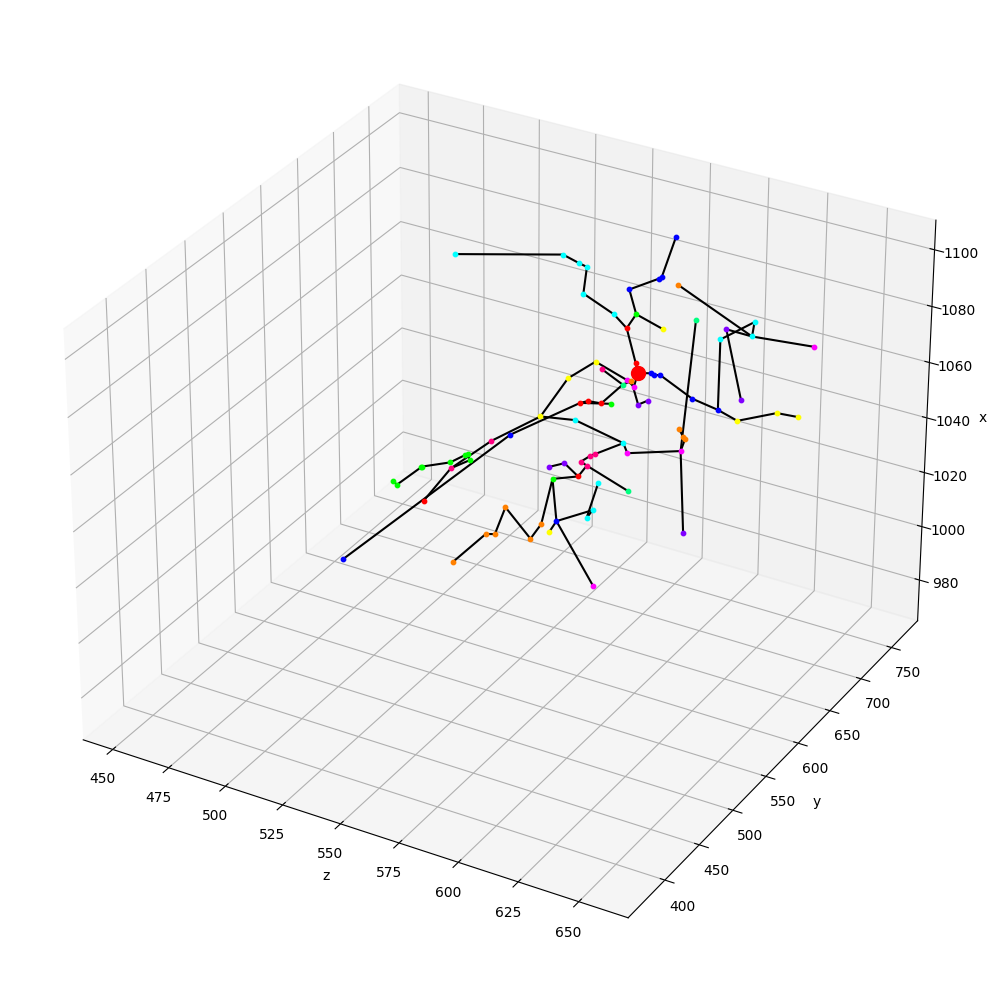

<Figure size 800x800 with 0 Axes>

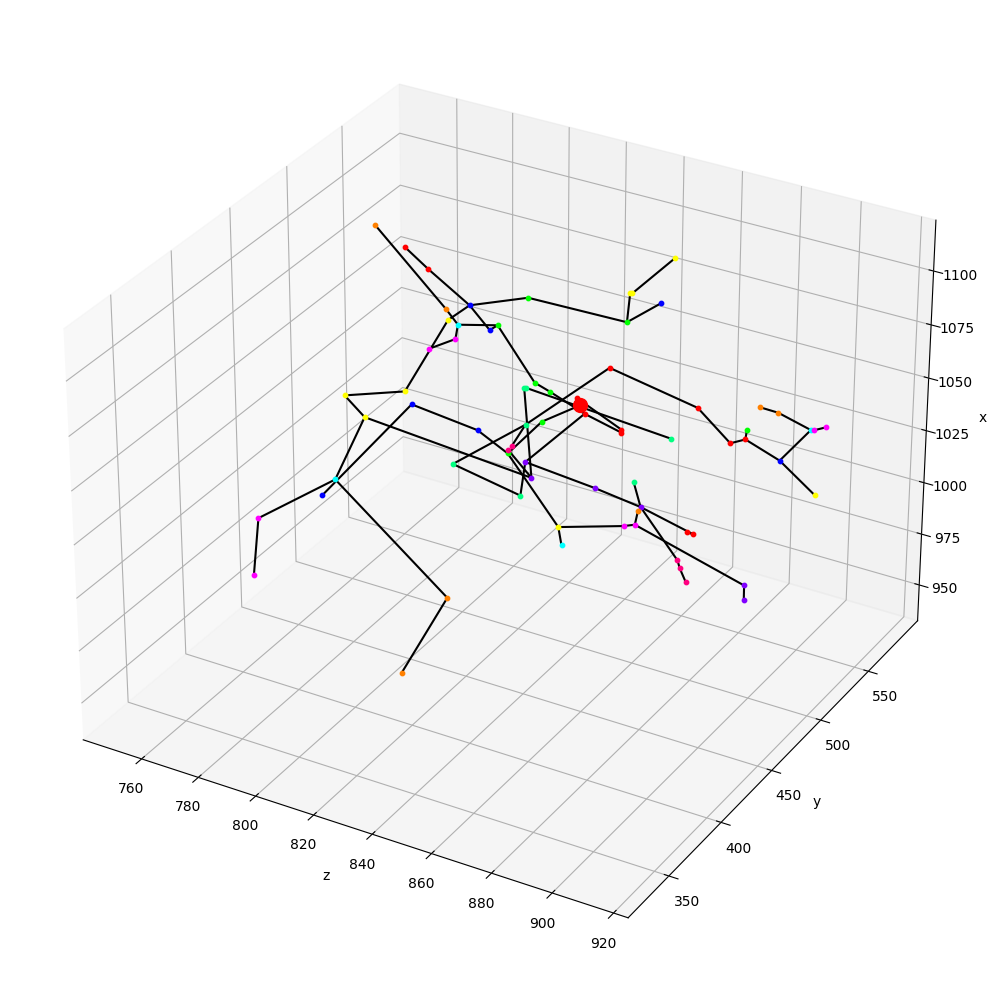

<Figure size 800x800 with 0 Axes>

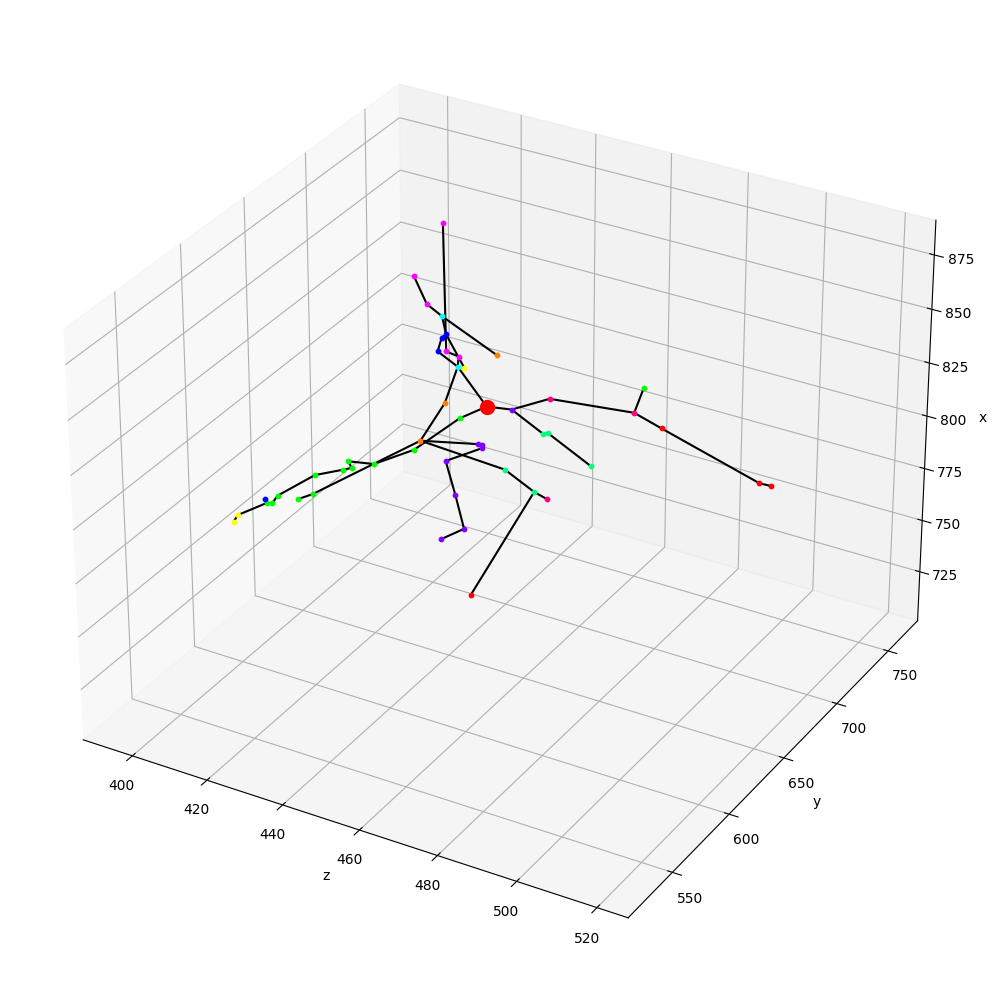

KeyError: 657643

<Figure size 800x800 with 0 Axes>

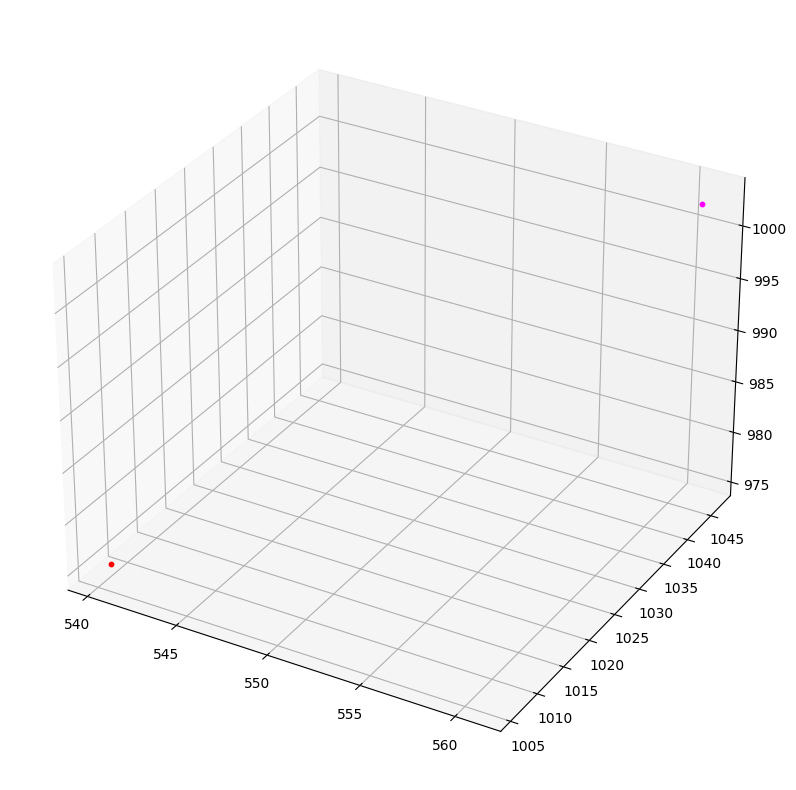

In [26]:
cell_ids = list(msts.keys())
print(cell_ids[:5])
for cell_id in cell_ids[:5]:
    mst = msts[cell_id]
    plt.figure(figsize=(8, 8))
    paths = plot_mst_3d(mst, synapses_by_cell.get_group(cell_id))
    plt.show()